In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import glob as glob

import hydra
from omegaconf import OmegaConf
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cohlib.observations import sample_obs
from cohlib.utils import add0, jax_boilerplate, pickle_save, pickle_open

import cohlib.confs.utils as conf
from cohlib.confs.latent import create_lrccn_basic_rank1
from cohlib.confs.config import get_sim_config

In [3]:
from hydra import initialize, compose
from hydra.core.config_store import ConfigStore
def omega(cfg):
    return OmegaConf.create(cfg)
# Create Gamma with new scaling
# How is Gamma created in script?
jax_boilerplate()

Platform:  cpu
28


In [5]:
# Create config - (incorporates overrides from from command line)
Config = get_sim_config()

with initialize(version_base=None, config_path="."):
    cfg = compose(
        config_name="config", 
        # overrides=["app.name=MyNewApp", "database.port=1234"]
    )
    # print(cfg)
    
lcfg = cfg.latent
ocfg = cfg.obs

latent_dir = conf.get_latent_dir(lcfg)
obs_dir = conf.get_obs_dir(ocfg, latent_dir)

lcfg.scale_power_target = 1e5

In [6]:
lrccn = create_lrccn_basic_rank1(lcfg)
lrk_sample_seed = lcfg.seed #+ lcfg.L
lrk_sample = jr.key(lrk_sample_seed)
zs_nz = lrccn.sample_nz(lrk_sample, lcfg.L)
freqs = lrccn.freqs
nz = lrccn.nz
lcfg_resolved = OmegaConf.to_container(lcfg, resolve=True)
latent_save = {'lcfg': lcfg_resolved, 'zs_nz': zs_nz, 'nz': nz, 'freqs': freqs}
latent_savename = os.path.join(latent_dir, 'latent_sim.pkl')
pickle_save(latent_save, latent_savename) 
zs_existed = False

num_freqs = freqs.size
zs = jnp.zeros((num_freqs, lcfg.K, lcfg.L), dtype=complex)
zs = zs.at[nz,:,:].set(zs_nz)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

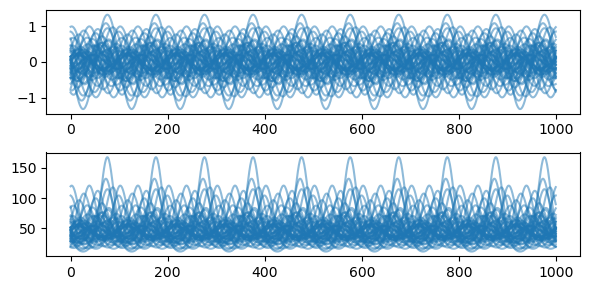

In [7]:
L = lcfg.L
k = 0
l = 0
mu = 3.8
lams = jnp.exp(mu + xs)
L_plot = L
fig, ax = plt.subplots(2,1,figsize=(6,3))
for l in range(L_plot):
    ax[0].plot(xs[:,k,l], color='tab:blue', alpha=0.5)
    ax[1].plot(lams[:,k,l], color='tab:blue', alpha=0.5)
plt.tight_layout()

In [8]:
zs[9,:,:]

Array([[  77.33649 -1.65145218e+02j, -223.53062 +2.81536438e+02j,
        -230.04642 +1.99391212e+01j,   73.27757 -9.85917816e+01j,
        -155.8399  +4.67581902e+01j,   20.959995-1.23363556e+02j,
         -93.33943 -2.56167679e+01j,   -9.613456+1.62042496e+02j,
         155.70836 +7.90012789e+00j, -399.47852 +4.38798561e+01j,
         -60.906708-4.35447388e+02j,  -94.58585 -2.44879189e+01j,
        -375.19684 -3.26278137e+02j,  -81.99465 +5.35740906e+02j,
         328.5315  +3.56486969e+02j,   75.73447 -7.14960632e+01j,
         318.3355  -1.11228355e+02j,   63.0295  -2.01973541e+02j,
         -25.254688-1.69950638e+02j,  -46.093445+8.07919998e+01j,
          46.685184-8.42296448e+01j,   33.695755-7.36251373e+01j,
         154.29721 +1.42101654e+02j,  235.86441 +9.70818329e+01j,
        -225.0606  -5.09848328e+01j,   67.093056+3.07636047e+02j,
        -147.42557 -1.99377075e+02j,  491.99716 -6.97045212e+01j,
          75.056854-1.57352432e+02j,  176.83429 -3.42964966e+02j,
         -

In [9]:
def sample_func(scale, K, mu, seed):
    Config = get_sim_config()

    with initialize(version_base=None, config_path="."):
        cfg = compose(
            config_name="config", 
            # overrides=["app.name=MyNewApp", "database.port=1234"]
        )
        # print(cfg)
        
    lcfg = cfg.latent
    ocfg = cfg.obs
    lcfg.K = K

    lcfg.scale_power_target = scale

    lrccn = create_lrccn_basic_rank1(lcfg)
    lrk_sample_seed = seed
    lrk_sample = jr.key(lrk_sample_seed)
    zs_nz = lrccn.sample_nz(lrk_sample, lcfg.L)
    freqs = lrccn.freqs
    nz = lrccn.nz

    num_freqs = freqs.size
    zs = jnp.zeros((num_freqs, lcfg.K, lcfg.L), dtype=complex)
    zs = zs.at[nz,:,:].set(zs_nz)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    obs_params = ocfg
    ocfg.seed = seed
    ocfg.mu = mu
    obs = sample_obs(xs, obs_params)

    return zs_nz, xs, obs

In [10]:
from cohlib.utils import naive_estimator
from cohlib.plot import get_eigval
def estimate_d1_func(zs_nz, obs, jind_nz=0, eigrank=1):
    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    eigval_oracle = get_eigval(gamma_oracle[jind_nz,:,:], eigrank)
    nz_model = 9

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    eigval_naive = get_eigval(naive_est[jind_nz,:,:], eigrank)

    return eigval_oracle, eigval_naive

In [11]:
L = 50
scale = 5e4
K = 5
mu = 2.3
seed = 7

lred = 1

zt, xt, obst = sample_func(scale, K, mu, seed)
lamt = jnp.exp(mu+xt)
print(lamt.mean())

10.638841


In [12]:
obst.shape

(1000, 5, 50)

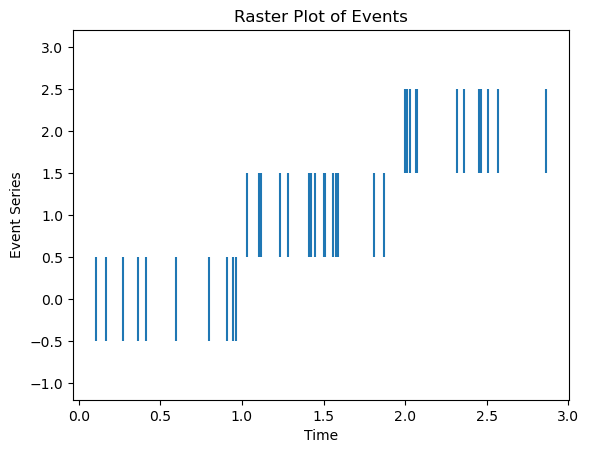

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: each sub-array represents event times for one series
data = [np.random.rand(10), 
        np.random.rand(15) + 1,
        np.random.rand(12) + 2]

# Create the eventplot
fig, ax = plt.subplots()
ax.eventplot(data, orientation='horizontal')

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Event Series')
ax.set_title('Raster Plot of Events')

# Show the plot
plt.show()

In [14]:
data

[array([0.16588712, 0.79865088, 0.96445991, 0.36243153, 0.10329892,
        0.27009451, 0.91058983, 0.4139482 , 0.59768724, 0.943743  ]),
 array([1.41111318, 1.8700084 , 1.57544586, 1.50817229, 1.80932908,
        1.11749118, 1.50145312, 1.28458888, 1.23229454, 1.44473237,
        1.5866689 , 1.4208607 , 1.03273397, 1.56009024, 1.10268716]),
 array([2.02819139, 2.45248022, 2.01324523, 2.50540821, 2.86593176,
        2.00023245, 2.31727172, 2.5671684 , 2.46402166, 2.06948726,
        2.35994731, 2.07342784])]

In [15]:
l = 0
dataraster = [np.where(obst[:,k,l])[0] for k in range(K)]

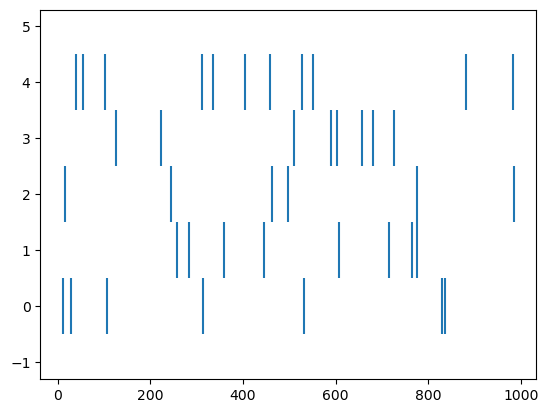

In [16]:
plt.eventplot(dataraster)

In [17]:
import seaborn as sns

In [18]:
sns.set_palette('muted')
current_palette = sns.color_palette()
sns.set_context("paper")

In [28]:
save_path = '/projectnb/stephenlab/jtauber/cohlib/experiments/poster_figures'

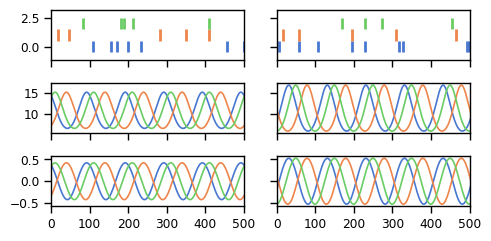

In [29]:
ls = [7,8]
Kshow = 3
# colors = ['tab:blue', 'tab:green', 'tab:orange']

c = 0
colors = current_palette[c:c+3]

fig, ax = plt.subplots(3,2,figsize=(5,2.5), sharex=True, sharey='row')
for i, l in enumerate(ls):
    dataraster = [np.where(obst[:,k,l])[0] for k in range(Kshow)]
    ax[0,i].eventplot(dataraster, linewidths=2, colors=colors)

    for k in range(Kshow):
        ax[1,i].plot(lamt[:,k,l], color=colors[k], alpha=1.0)
        ax[2,i].plot(xt[:,k,l], color=colors[k], alpha=1.0)
    # ax[0].plot(xt[:,0,lred], color='tab:red', alpha=0.5, linewidth=3)
    # ax[0,i].set_title(r'$x_t^k$')
    # ax[1].plot(lamt[:,0,lred], color='tab:red', alpha=0.5, linewidth=3)
    # ax[1,i].set_title(r'$\lambda_t^k$')
    # ax[2].plot(obst[:,0,lred], color='tab:red')
    # ax[2,i].set_title(r'$n_t^k$')
    # ax[2,i].set_xlabel('Time (ms)', weight='bold')
    for n in range(3):
        ax[n,i].set_xlim([0,500])
        # ax[n,i].set_yticklabels(ax[n,i].get_yticks(), fontsize=10, weight='bold');
        # ax[n,i].set_xticklabels(ax[n,i].get_xticks(), fontsize=10, weight='bold');

    plt.tight_layout()
save_name = os.path.join(save_path, 'test.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")

In [20]:
zt.shape

(1, 5, 50)

In [21]:
zt[:,k,l].real

Array([-262.76688], dtype=float32)

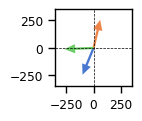

In [30]:
l = 8
zr = zt[:,:Kshow,l].real.squeeze()
zi = zt[:,:Kshow,l].imag.squeeze()

sns.set_palette('muted')
current_palette = sns.color_palette()
sns.set_context("paper")
colors = current_palette[c:c+3]
fig, ax = plt.subplots(figsize=(1,1))
ax.quiver([0, 0, 0], [0, 0, 0], zr, zi, color=colors, angles='xy', scale_units='xy', scale=1, width=0.03, headwidth=4, headlength=4.5)
# ax.scatter(zt[:,:Kshow,l].real, zt[:,:Kshow,l].imag, marker='.', s=300, color=colors, alpha=1.0)
    # ax[1].plot(lamt[:,k,l], color=colors[k], alpha=1.0)
ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax.axvline(0, color='k', linestyle='--', linewidth=0.5)
ax.set_xlim([-350, 350])
ax.set_ylim([-350, 350])
# ax.set_xlabel('Real', fontsize=14)
# ax.set_ylabel('Imag', fontsize=14)
ax.set_aspect('equal')
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=14) 
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=14) 
# ax.set_title(r'$z_j^{k}$', fontsize=20)
# ax.legend()
save_name = os.path.join(save_path, 'test.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")

In [33]:
zr = zt[:,:Kshow,l].real.squeeze()
zi = zt[:,:Kshow,l].imag.squeeze()

(-350.0, 350.0)

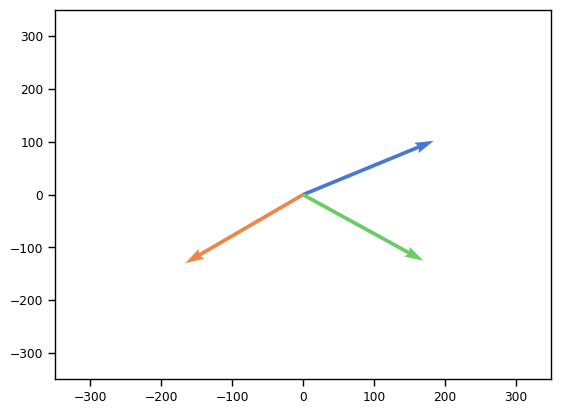

In [37]:
lim = 350
fig, ax = plt.subplots()
ax.quiver([0, 0, 0], [0, 0, 0], zr, zi, color=colors, angles='xy', scale_units='xy', scale=1)
ax.set_xlim([-lim,lim])
ax.set_ylim([-lim,lim])
